In [190]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(font_scale=1.5)
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Посмотрим на примере данных по оттоку клиентов из телеком-компании.

Важно: XGBoost поддерживает только числовые признаки. Поэтому текстовые признаки требуют предобработки

Для обучения с Xgboost данные должны быть представлены в виде объекта DMatrix, предназначенного для представления разреженных данных. Его можно инициализировать через:

* текстовый формат libsvm,
* Numpy 2D array (чаще всего)
* бинарный буфер-файл XGBoost

In [191]:
df = pd.read_csv("data/telecom_churn.csv")

In [192]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [193]:
state_enc = LabelEncoder()
df["State"] = state_enc.fit_transform(df["State"])
df["International plan"] = (df["International plan"] == "Yes").astype("int")
df["Voice mail plan"] = (df["Voice mail plan"] == "Yes").astype("int")
df["Churn"] = (df["Churn"]).astype("int")

In [194]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [195]:
df.shape

(3333, 20)

In [196]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Churn", axis=1),
    df["Churn"],
    test_size=0.3,
    stratify=df["Churn"],
    random_state=17,
)

### Cтандартный Python-интерфейс.

In [197]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)


In [198]:
print(dtrain.num_row(), dtrain.num_col())
print(dtrain.num_row(), dtrain.num_col())


2333 19
2333 19


In [199]:
print(np.mean(dtrain.get_label()))
print(np.mean(dtest.get_label()))


0.14487784
0.145


* бинарная классификация ('objective':'binary:logistic')
* ограничим глубину деревьев ('max_depth':3)
* не хотим лишнего вывода ('silent':1)
* проведем 50 итераций бустинга
* шаг градиентного спуска довольно большой ('eta':1) - алгоритм будет обучаться быстро и "агрессивно" (лучше результаты будут, если уменьшить eta и увеличить число итераций)

In [200]:
params = {'objective': 'binary:logistic', 'max_depth': 3, 'silent': 1, 'eta': 1}

num_rounds = 50

In [201]:
xgb_model = xgb.train(params, dtrain, num_rounds)

[21:43:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.



In [202]:
watchlist = [(dtest, "test"), (dtrain, "train")]  # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[21:43:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	test-logloss:0.33282	train-logloss:0.29641
[1]	test-logloss:0.27720	train-logloss:0.21573
[2]	test-logloss:0.23202	train-logloss:0.16440
[3]	test-logloss:0.22528	train-logloss:0.14914
[4]	test-logloss:0.22919	train-logloss:0.14201
[5]	test-logloss:0.22992	train-logloss:0.13463
[6]	test-logloss:0.23115	train-logloss:0.13057
[7]	test-logloss:0.22990	train-logloss:0.12561
[8]	test-logloss:0.22937	train-logloss:0.12286
[9]	test-logloss:0.23540	train-logloss:0.11519
[10]	test-logloss:0.22859	train-logloss:0.10849
[11]	test-logloss:0.22711	train-logloss:0.10452
[12]	test-logloss:0.22387	train-logloss:0.09907
[13]	test-logloss:0.22211	train-logloss:0.09270
[14]	test-logloss:0.22247	train-logloss:0.09032
[15]	test-logloss:0.22642	train-logloss:0.08833
[16]	test-logloss:0.22637	train-logloss:0.08658
[17]	test-logloss:0.22614	train-logloss:0.08267
[18]	t

c:\Users\lorex\anaconda3\envs\DataScience\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [203]:
preds_prob = xgb_model.predict(dtest)

In [204]:
predicted_labels = preds_prob > 0.5
print(
    "Accuracy and F1 on the test set are: {} and {}".format(
        round(accuracy_score(y_test, predicted_labels), 3),
        round(f1_score(y_test, predicted_labels), 3),
    )
)

Accuracy and F1 on the test set are: 0.935 and 0.749


### Интерфейс Sklearn.

In [205]:
from xgboost import XGBClassifier

In [206]:
params = {
    "objective": "binary:logistic",
    "max_depth": 3,
    "learning_rate": 1.0,
    "silent": 1.0,
    "n_estimators": 50,
}

In [207]:
xgb_model = XGBClassifier(**params).fit(X_train, y_train)

[21:43:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.



In [208]:
preds_prob = xgb_model.predict(X_test)

In [209]:
predicted_labels = preds_prob > 0.5
print(
    "Accuracy and F1 on the test set are: {} and {}".format(
        round(accuracy_score(y_test, predicted_labels), 3),
        round(f1_score(y_test, predicted_labels), 3),
    )
)

Accuracy and F1 on the test set are: 0.935 and 0.749


### Оценка важности признаков.

#### Обучение модели

In [210]:
params = {'objective': 'binary:logistic', "max_depth": 3, 'silent': 1, "eta": 0.5}

num_rounds = 50 # Количество деревьев.

In [211]:
watchlist = [(dtrain, 'train'), (dtest, "test")]

xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[21:43:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-logloss:0.42330	test-logloss:0.44114
[1]	train-logloss:0.31389	test-logloss:0.34620
[2]	train-logloss:0.25487	test-logloss:0.29674
[3]	train-logloss:0.21883	test-logloss:0.27432
[4]	train-logloss:0.19157	test-logloss:0.24807
[5]	train-logloss:0.17364	test-logloss:0.23248
[6]	train-logloss:0.16601	test-logloss:0.23101
[7]	train-logloss:0.15963	test-logloss:0.22841
[8]	train-logloss:0.15506	test-logloss:0.22418
[9]	train-logloss:0.14670	test-logloss:0.22110
[10]	train-logloss:0.14267	test-logloss:0.22245
[11]	train-logloss:0.13712	test-logloss:0.22189
[12]	train-logloss:0.13290	test-logloss:0.22186
[13]	train-logloss:0.12920	test-logloss:0.21857
[14]	train-logloss:0.12593	test-logloss:0.21858
[15]	train-logloss:0.12292	test-logloss:0.21758
[16]	train-logloss:0.12134	test-logloss:0.21832
[17]	train-logloss:0.11934	test-logloss:0.21961
[18]	t

c:\Users\lorex\anaconda3\envs\DataScience\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


#### Важность признаков.

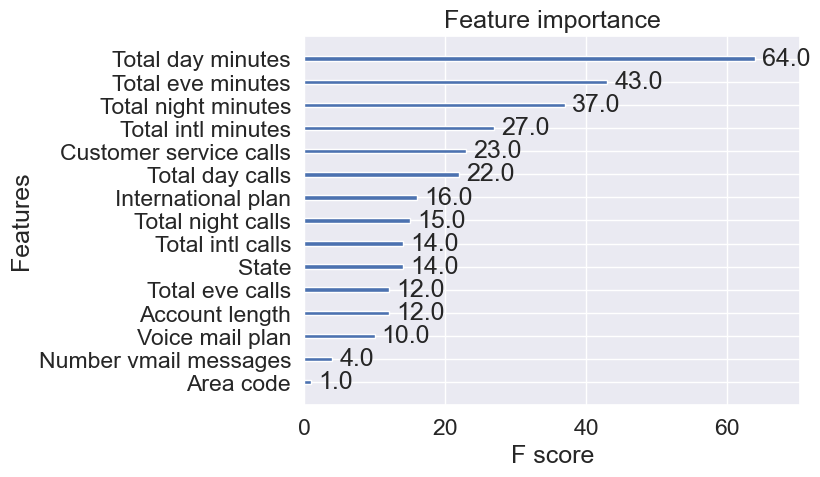

In [212]:
xgb.plot_importance(xgb_model);

In [213]:
importances = xgb_model.get_fscore()
importances

{'State': 14.0,
 'Account length': 12.0,
 'Area code': 1.0,
 'International plan': 16.0,
 'Voice mail plan': 10.0,
 'Number vmail messages': 4.0,
 'Total day minutes': 64.0,
 'Total day calls': 22.0,
 'Total eve minutes': 43.0,
 'Total eve calls': 12.0,
 'Total night minutes': 37.0,
 'Total night calls': 15.0,
 'Total intl minutes': 27.0,
 'Total intl calls': 14.0,
 'Customer service calls': 23.0}

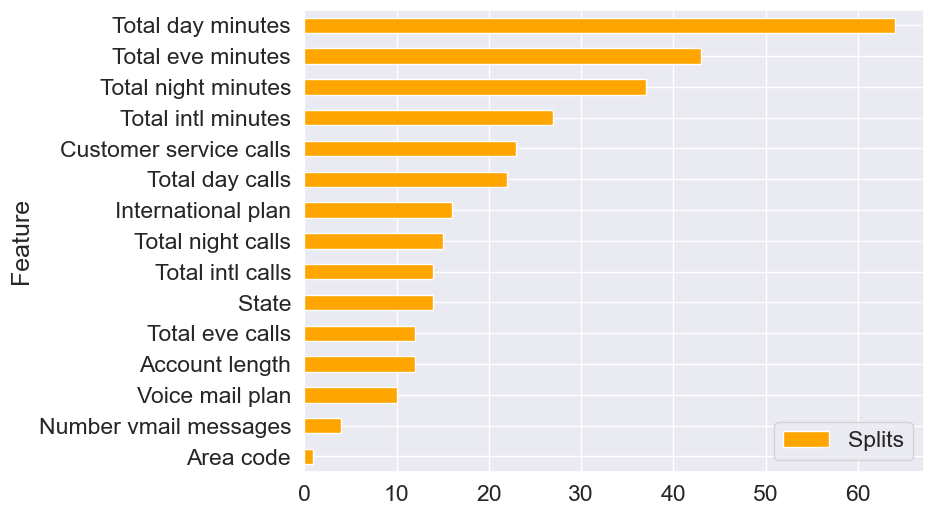

In [214]:
# create df
importance_df = pd.DataFrame(
    {"Splits": list(importances.values()), "Feature": list(importances.keys())}
)
importance_df.sort_values(by="Splits", inplace=True)
importance_df.plot(kind="barh", x="Feature", figsize=(8, 6), color="orange");

### Побрьба с недообучением и переобучением.

In [215]:
from scipy.sparse import vstack
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, validation_curve

In [216]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=8,
    n_redundant=3,
    n_repeated=2,
    random_state=42,
)

In [217]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [218]:
default_params = {
    "objective": "binary:logistic",
    "max_depth": 1,
    "learning_rate": 0.3,
    "silent": 1.0,
    "seed": 42,
}

n_estimators_range = np.linspace(1, 200, 10).astype("int")

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X,
    y,
    param_name="n_estimators",
    param_range=n_estimators_range,
    cv=cv.split(X, y),
    scoring="accuracy",
    n_jobs=-1,
)

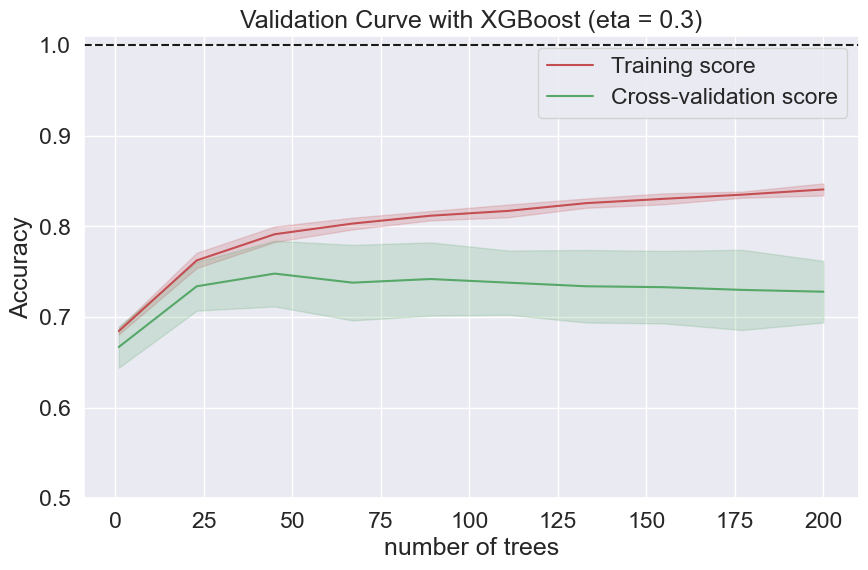

Best cross-validation result (0.75) obtained for 45 trees


In [219]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range, train_scores_mean, label="Training score", color="r")

plt.plot(
    n_estimators_range, test_scores_mean, label="Cross-validation score", color="g"
)

plt.fill_between(
    n_estimators_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="r",
)

plt.fill_between(
    n_estimators_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="g",
)

plt.axhline(y=1, color="k", ls="dashed")

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print(
    "Best cross-validation result ({0:.2f}) obtained for {1} trees".format(
        test_scores_mean[i], n_estimators_range[i]
    )
)

Для уменьшения сложности модели можно:

* использовать меньше признаков (например, отбор)
* использовать больше объектов (например, искусственно созданных)
* увеличить регуляризацию

В случае XGBoost можно:

* уменьшать максимальную глубину деревьев(max_depth)
* увеличивать значение параметра min_child_weight
* величивать значение параметра gamma
* добавлять больше "случайности" за счет параметров subsample и colsample_bytree
* увеличивать значение паарметров регуляризации lambda и alpha

In [220]:
new_params = {
    "objective": "binary:logistic",
    "max_depth": 2,  # changed
    "learning_rate": 0.3,
    "silent": 1.0,
    "colsample_bytree": 0.6,  # added
    "subsample": 0.7,  # added
    "seed": 42,
}

n_estimators_range = np.linspace(1, 200, 10).astype("int")

train_scores, test_scores = validation_curve(
    XGBClassifier(**new_params),
    X,
    y,
    param_name="n_estimators",
    param_range=n_estimators_range,
    cv=cv.split(X, y),
    scoring="accuracy",
)

[21:43:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[21:43:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[21:43:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[21:43:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[21:43:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[21:43:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[21:43:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[21:43:17] WARNING: 

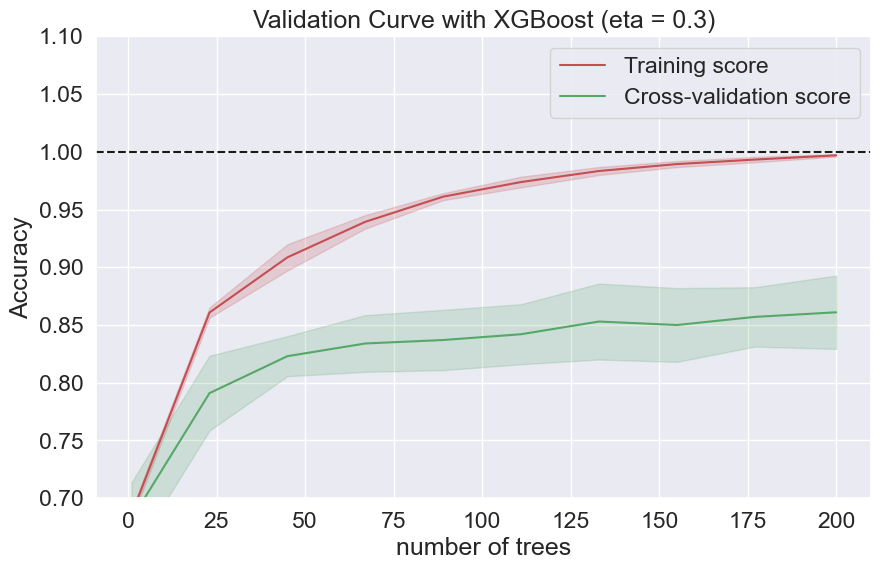

Best cross-validation result (0.86) obtained for 200 trees


In [221]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range, train_scores_mean, label="Training score", color="r")

plt.plot(
    n_estimators_range, test_scores_mean, label="Cross-validation score", color="g"
)

plt.fill_between(
    n_estimators_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="r",
)

plt.fill_between(
    n_estimators_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="g",
)

plt.axhline(y=1, color="k", ls="dashed")

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print(
    "Best cross-validation result ({0:.2f}) obtained for {1} trees".format(
        test_scores_mean[i], n_estimators_range[i]
    )
)

### Xgboost и Hyperopt в соревновании Kaggle Forest Cover Type Prediction

In [222]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

In [223]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [224]:
def write_to_submission_file(
    predicted_labels, out_file, target="Cover_Type", index_label="Id", init_index=15121
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(init_index, predicted_labels.shape[0] + init_index),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

In [225]:
train_df.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [226]:
train_df["Under_water"] = train_df.Vertical_Distance_To_Hydrology < 0
test_df["Under_water"] = test_df.Vertical_Distance_To_Hydrology < 0

In [227]:
train_df["EVDtH"] = train_df.Elevation - train_df.Vertical_Distance_To_Hydrology
test_df["EVDtH"] = test_df.Elevation - test_df.Vertical_Distance_To_Hydrology

train_df["EHDtH"] = train_df.Elevation - train_df.Horizontal_Distance_To_Hydrology * 0.2
test_df["EHDtH"] = test_df.Elevation - test_df.Horizontal_Distance_To_Hydrology * 0.2

In [228]:
train_df["Distanse_to_Hydrolody"] = (
    train_df["Horizontal_Distance_To_Hydrology"] ** 2
    + train_df["Vertical_Distance_To_Hydrology"] ** 2
) ** 0.5
test_df["Distanse_to_Hydrolody"] = (
    test_df["Horizontal_Distance_To_Hydrology"] ** 2
    + test_df["Vertical_Distance_To_Hydrology"] ** 2
) ** 0.5

train_df["Hydro_Fire_1"] = (
    train_df["Horizontal_Distance_To_Hydrology"]
    + train_df["Horizontal_Distance_To_Fire_Points"]
)
test_df["Hydro_Fire_1"] = (
    test_df["Horizontal_Distance_To_Hydrology"]
    + test_df["Horizontal_Distance_To_Fire_Points"]
)

train_df["Hydro_Fire_2"] = abs(
    train_df["Horizontal_Distance_To_Hydrology"]
    - train_df["Horizontal_Distance_To_Fire_Points"]
)
test_df["Hydro_Fire_2"] = abs(
    test_df["Horizontal_Distance_To_Hydrology"]
    - test_df["Horizontal_Distance_To_Fire_Points"]
)

train_df["Hydro_Road_1"] = abs(
    train_df["Horizontal_Distance_To_Hydrology"]
    + train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Hydro_Road_1"] = abs(
    test_df["Horizontal_Distance_To_Hydrology"]
    + test_df["Horizontal_Distance_To_Roadways"]
)

train_df["Hydro_Road_2"] = abs(
    train_df["Horizontal_Distance_To_Hydrology"]
    - train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Hydro_Road_2"] = abs(
    test_df["Horizontal_Distance_To_Hydrology"]
    - test_df["Horizontal_Distance_To_Roadways"]
)

train_df["Fire_Road_1"] = abs(
    train_df["Horizontal_Distance_To_Fire_Points"]
    + train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Fire_Road_1"] = abs(
    test_df["Horizontal_Distance_To_Fire_Points"]
    + test_df["Horizontal_Distance_To_Roadways"]
)

train_df["Fire_Road_2"] = abs(
    train_df["Horizontal_Distance_To_Fire_Points"]
    - train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Fire_Road_2"] = abs(
    test_df["Horizontal_Distance_To_Fire_Points"]
    - test_df["Horizontal_Distance_To_Roadways"]
)

In [229]:
y = train_df["Cover_Type"]
train_df = train_df.drop(["Cover_Type", "Id"], axis=1)
test_df = test_df.drop(["Id"], axis=1)

In [230]:
y = y - 1

In [232]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [242]:
def score(params):
    from sklearn.metrics import log_loss
    
    print("Training with params")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_test, y_test)
    
    model = xgb.train(params, dtrain, params['num_round'])
    prediction = model.predict(dvalid).reshape((X_test.shape[0], 7))
    score = log_loss(y_test, prediction)
    print(f"\t Score {score}\n\n")
    
    return {"loss": score, "status": STATUS_OK}
    

In [244]:
def optimize(trials):
    space = {
        "num_round": 100,
        'learning_rate': hp.quniform('eta', 0.005, 0.05, 0.005),
        'max_depth': hp.quniform('max_depth', 3, 14, 1),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
        "gamma": hp.quniform("gamma", 0.5, 1, 0.01),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 1, 0.05),
        "num_class": 7,
        "eval_metric": "merror",
        "objective": "multi:softprob",
        "nthread": 4,
        "silent": 1,
    }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10)
    return best

In [240]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df, y, test_size=0.3, random_state=17
)

In [245]:
trials = Trials()
best_params = optimize(trials)
best_params

Training with params                                  
{'colsample_bytree': 0.4, 'eval_metric': 'merror', 'gamma': 0.52, 'learning_rate': 0.045, 'max_depth': 7.0, 'min_child_weight': 2.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.9}
[23:47:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.

	 Score 0.4797327742883818                            


Training with params                                                            
{'colsample_bytree': 0.75, 'eval_metric': 'merror', 'gamma': 0.8300000000000001, 'learning_rate': 0.01, 'max_depth': 13.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.75}
[23:47:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.


{'colsample_bytree': 0.4,
 'eta': 0.045,
 'gamma': 0.52,
 'max_depth': 7.0,
 'min_child_weight': 2.0,
 'subsample': 0.9}

In [247]:
best_params["max_depth"] = int(best_params["max_depth"])
best_params["num_class"] = 7
best_params["eval_metric"] = "merror"
best_params["objective"] = "multi:softprob"
best_params["nthread"] = 4
best_params["silent"] = 1

In [248]:
dtrain = xgb.DMatrix(train_df, y)

In [249]:
%%time
xgbCvResult = xgb.cv(
    best_params, dtrain, num_boost_round=500, nfold=3, early_stopping_rounds=50
)

[23:56:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[23:56:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[23:56:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

CPU times: total: 3min 21s
Wall time: 51.1 s


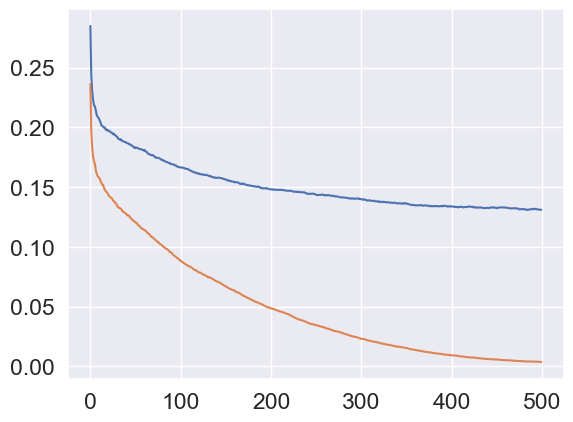

In [251]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["test-merror-mean"])
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["train-merror-mean"]);

In [253]:
best_num_round = np.argmin(xgbCvResult["test-merror-mean"])
best_num_round

484

In [254]:
bestXgb = xgb.train(best_params, dtrain, num_boost_round=best_num_round)

[00:01:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.



In [255]:
dtest = xgb.DMatrix(test_df)

In [256]:
xgboost_predict_proba = bestXgb.predict(dtest)

In [257]:
xgboost_prediction = np.argmax(xgboost_predict_proba, axis=1)

In [258]:
xgboost_prediction += 1

In [259]:
write_to_submission_file(xgboost_prediction, "forest_cover_type_xgboost.csv")